In [1]:
import os
import sys
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns

# https://stackoverflow.com/questions/34478398/import-local-function-
# from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import local_module as local

# Data Caveats
- For the PER_TYP column, several categories of non-occupants are mapped to the "Other/unknown non-occupant" category.
- 

In [2]:
yr_range = [x for x in range(1975, 2021)] # list of years for later use

# all the forms of the person.csv filename found in FARS
person_names = [
    "person.csv",
    "person.CSV",
    "PERSON.csv",
    "PERSON.CSV",
    "Person.CSV",
    "Person.csv"
]

# create a list of paths to access the FARS FTP site
paths = [
    "https://static.nhtsa.gov/nhtsa/downloads/FARS/" + 
    str(x) + 
    "/National/FARS" + 
    str(x) + 
    "NationalCSV.zip" for x in yr_range
]

# test
paths[10]

'https://static.nhtsa.gov/nhtsa/downloads/FARS/1985/National/FARS1985NationalCSV.zip'

In [3]:
dfs = {} # initialize dictionary to hold dfs of person.csv

for i in range(len(yr_range)):
    # url to data on NHTSA FTP site
    url = paths[i]
    # get function to retrieve CSV file from ZIP
    df = local.fetch_multi_csv_zip_from_url(
        url, 
        filenames=person_names, 
        encoding_errors="surrogateescape", # deal with encoding errors
        low_memory=False # deal with multiple dtypes in one column
    )
    # add year and df of person.csv as 
    # key:value pair in dict
    dfs[yr_range[i]] = df

# test access df by year key
# dfs[1975].head()

In [4]:
fatalities = pd.DataFrame() # initialize dataframe

for year, df in dfs.items(): # access year and associated person.csv dataframe
    
    # filter and remap values in dataframe
    df = df.loc[df["INJ_SEV"] == 4] # filter to only fatalities
    # remap values in the PER_TYP column, 
    # and combine unknown/other non-occupant categories 
    df = local.remap_PER_TYP(
        person_file=df, 
        year=year,
        combine=True
    )
    
    # reform dataframe
    grouped = df.groupby("PER_TYP") # group by PER_TYP column
    count = grouped.size().reset_index() # count fatalities in each group, make into df
    count.rename(columns={0: year}, inplace=True) # rename column to year
    count = count.melt(id_vars="PER_TYP", value_vars=year, var_name="YEAR", value_name="FATALITIES") # tidy
    fatalities = pd.concat([fatalities, count]) # combine into single dataframe

In [5]:
# resetting and dropping non-unique index
# from building dataframe
fatalities.reset_index(inplace=True)
fatalities.drop(columns="index", inplace=True)
fatalities

,PER_TYP,YEAR,FATALITIES
0,Bicyclist,1975,1003
1,Driver,1975,23652
2,Other/unknown non-occupant,1975,81
3,Passenger,1975,12273
4,Pedestrian,1975,7516
...,...,...,...
225,Bicyclist,2020,938
226,Driver,2020,24787
227,Other/unknown non-occupant,2020,255
228,Passenger,2020,6328


In [6]:
# calculate total fatalities for the year
tot_fatalities = fatalities.groupby(['YEAR'])['FATALITIES'].agg('sum') # series
tot_fatalities_dict = tot_fatalities.to_dict() # create a dictionary to lookup total fatalities by year

# calculate percentage of total fatalities for each per_typ
fatalities["P_FATALITIES"] = (fatalities["FATALITIES"] / fatalities["YEAR"].map(tot_fatalities_dict))

<AxesSubplot:xlabel='YEAR', ylabel='FATALITIES'>

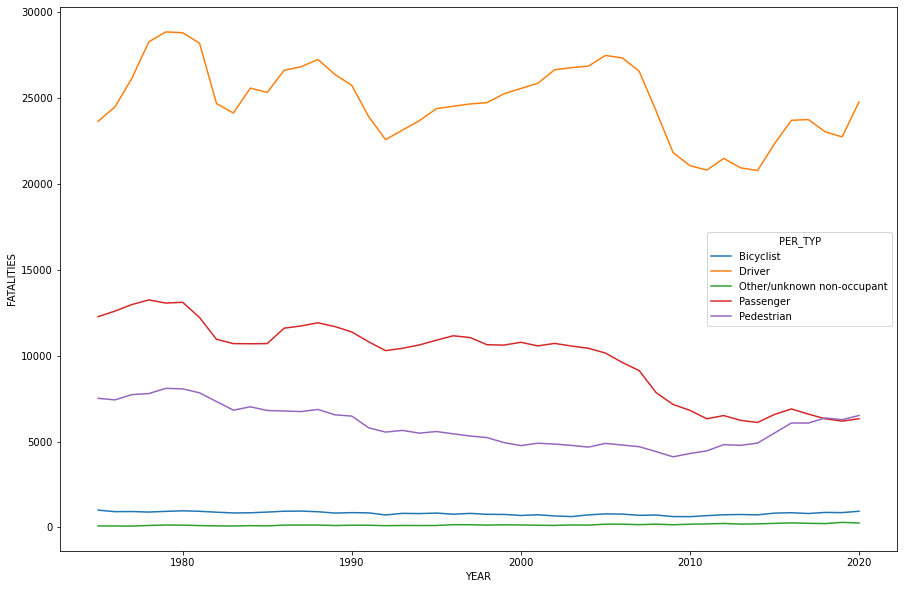

In [7]:
# plot absolute fatalities over full year range
f, ax = plt.subplots(1, figsize=(15,10))

sns.lineplot(
    data=fatalities, 
    x="YEAR", 
    y="FATALITIES", 
    hue="PER_TYP",
    ax=ax
)

<AxesSubplot:xlabel='YEAR', ylabel='P_FATALITIES'>

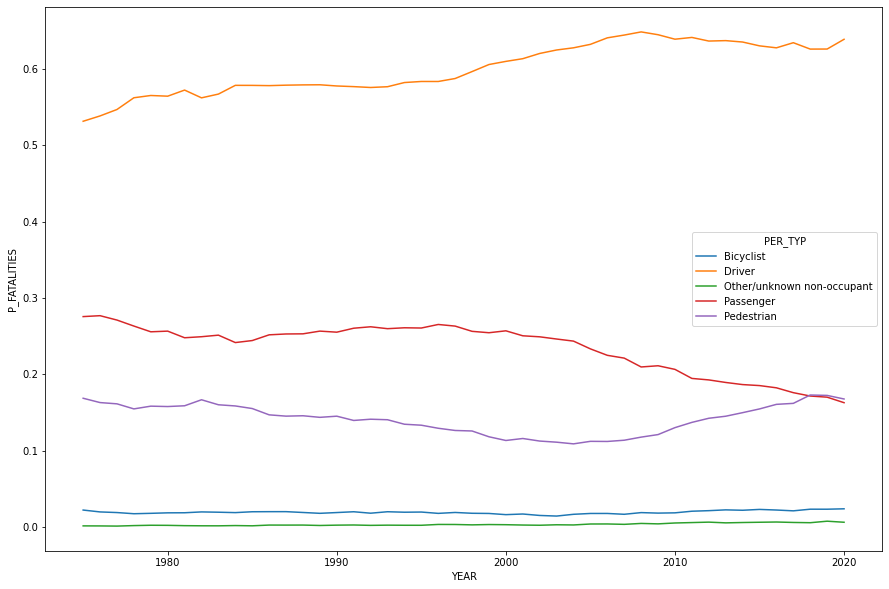

In [8]:
# plot percentage fatalities over full year range
f, ax = plt.subplots(1, figsize=(15,10))

sns.lineplot(
    data=fatalities, 
    x="YEAR", 
    y="P_FATALITIES", 
    hue="PER_TYP",
    ax=ax
)

In [9]:
# create a subset dataframe of non-motorists only
active_transpo = fatalities[
    (fatalities["PER_TYP"] == "Bicyclist") | 
    (fatalities["PER_TYP"] == "Pedestrian") | 
    (fatalities["PER_TYP"] == "Other/unknown non-occupant") 
]

In [10]:
# set style for plots
sns.set_style("darkgrid")

Text(0, 0.5, 'Percent of Total Fatalities')

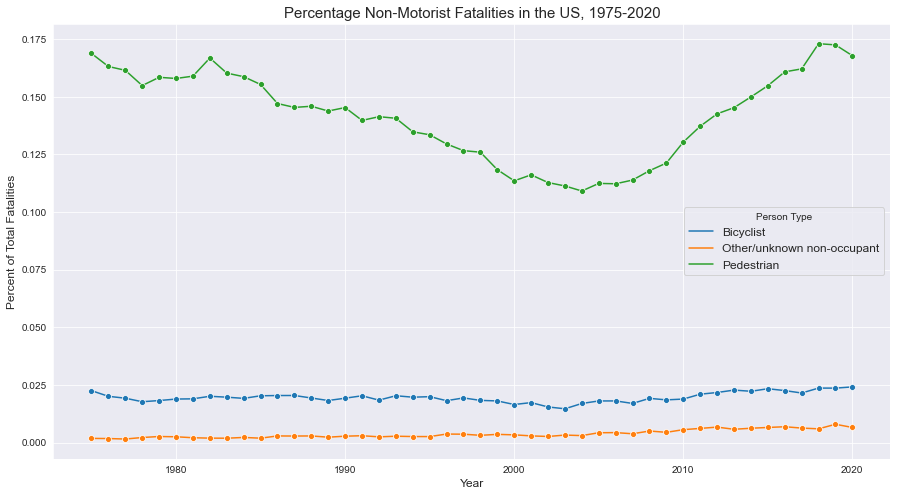

In [11]:
# plot percentage non-motorist fatalities over full year range
f, ax = plt.subplots(1, figsize=(15,8))

sns.lineplot(
    data=active_transpo, 
    x="YEAR", 
    y="P_FATALITIES", 
    hue="PER_TYP",
    marker="o",
    ax=ax
)
plt.legend(title="Person Type", fontsize=12)
ax.set_title("Percentage Non-Motorist Fatalities in the US, 1975-2020", size=15)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Percent of Total Fatalities", fontsize=12)

Text(0, 0.5, 'Total Fatalities')

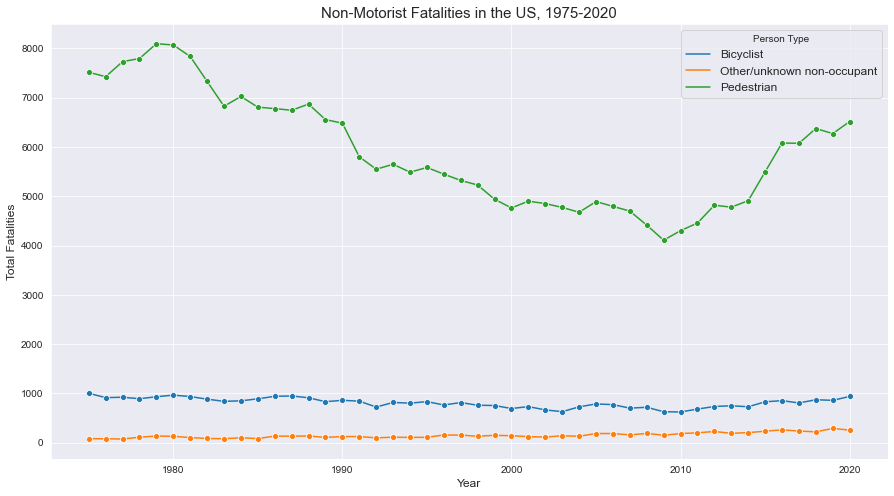

In [12]:
# plot percentage non-motorist fatalities over full year range
f, ax = plt.subplots(1, figsize=(15,8))
sns.lineplot(
    data=active_transpo, 
    x="YEAR", 
    y="FATALITIES", 
    hue="PER_TYP",
    marker="o",
    ax=ax
)
plt.legend(title="Person Type", fontsize=12)
ax.set_title("Non-Motorist Fatalities in the US, 1975-2020", size=15)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Total Fatalities", fontsize=12)

# Products

In [13]:
# fatalities by year for all per_typ categories
fatalities.head()

,PER_TYP,YEAR,FATALITIES,P_FATALITIES
0,Bicyclist,1975,1003,0.022527
1,Driver,1975,23652,0.531207
2,Other/unknown non-occupant,1975,81,0.001819
3,Passenger,1975,12273,0.275643
4,Pedestrian,1975,7516,0.168804


In [14]:
# fatalities by year for non_motorist per_typ categories only 
active_transpo.head()

,PER_TYP,YEAR,FATALITIES,P_FATALITIES
0,Bicyclist,1975,1003,0.022527
2,Other/unknown non-occupant,1975,81,0.001819
4,Pedestrian,1975,7516,0.168804
5,Bicyclist,1976,914,0.020078
7,Other/unknown non-occupant,1976,80,0.001757


In [15]:
# all fatalities by year
tot_fatalities.reset_index().head()

,YEAR,FATALITIES
0,1975,44525
1,1976,45523
2,1977,47878
3,1978,50331
4,1979,51093
